© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

# Regularization

**Regularization** in machine learning refers to a broad family of techniques used to **modify an optimization problem** to obtain solutions with certain desirable properties. Common use cases:

- **Ill-posed problems:** Regularization helps make such problems well-posed, e.g. by encouraging properties like **sparsity** or **smoothness**.
- **Overfitting:** Regularization helps prevent overfitting by encouraging models to favor simpler, more generalizable solutions.

## Types of Regularization

#### 1. ✅ **Explicit Regularization**

Explicit regularization involves adding a **penalty term** to the loss function, directly modifying the optimization problem. The general form is:
$$
\min_f \; \hat{\mathcal{L}}(f, X, Y) + \lambda \mathcal{P}(f)
$$

Where:
- $ \hat{\mathcal{L}}(f, X, Y) $ is the **empirical risk** (data-fitting term),
- $ \mathcal{P}(f) $ is a **regularization term** (e.g., norm, smoothness, sparsity),
- $ \lambda > 0 $ is the **regularization coefficient** controlling the trade-off.


#### 2. 🧠 **Implicit Regularization**

This arises naturally from the **structure of the model** or **properties of the optimization algorithm** (e.g., early stopping, inductive bias of gradient descent). It doesn’t involve an explicit penalty term and is generally harder to formalize or analyze. One famous example of implicit regularization is given in the next theorem.

> 📐 **Theorem (Implicit Regularization in Underdetermined OLS)**
> 
> Let $ X \in \mathbb{R}^{N \times P} $ with $P > N$, and suppose that $X$ has full row rank. Then the OLS problem:
> 
> $$ \min_{w \in \mathbb{R}^P} \|Xw - Y\|_2^2 $$
> 
> has **infinitely many solutions**, and among them, **Gradient Descent (GD)** initialized at $w = 0$ and using any step size $0< \eta \leq \dfrac{1}{\lambda_{\textup{max}}(X^\top X)}$ (where $\lambda_{\textup{max}}(X^\top X)$ is the largest eigenvalue of $X^\top X$) converges to:
> 
> $$ w^\star = \arg\min_{w} \|w\|_2 \quad \text{subject to } Xw = Y.$$

That is, GD converges to the **minimum-norm solution** — even though this was never explicitly required in the problem.

**Exercise:** Prove this result. 


## 📦 In This Class

We'll study two well-known examples of **explicit regularization** in linear models:

- **Ridge regression** ($\ell^2$ regularization)
- **Lasso regression** ($\ell^1$ regularization)

In addition, we'll cover two essential techniques commonly used in practical machine learning workflows:

- **Normalization** – to improve numerical stability and training efficiency
- **Cross-validation** – to evaluate model performance and tune hyperparameters

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data
We will work with the **wine dataset**, which we already used in one of the homeworks.

In [2]:
file_name = 'wine.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
column_names = ['Class','Alcohol', 'Malic acid','Ash', 'Alcalinity of ash', 'Magnesium',
               'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
                'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `wine.csv`...


In [3]:
df

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


## 🏔️ Ridge Regression

**Ridge regression** (also known as **Tikhonov regularization**) adds a penalty on the **$\ell^2$-norm** of the coefficients:

$$
\min_w \; \frac{1}{2N} \| Xw - Y \|_2^2 + \lambda \|w\|_2^2
$$

This addresses several issues inherent to Ordinary Least Squares (OLS), particularly in high-dimensional or poorly conditioned data:

#### 1. **Multicollinearity**
When features (columns of $X\in\mathbb{R}^{N\times P}$) are highly correlated, OLS becomes **unstable** — small changes in the data can lead to large changes in the solution.

This is because there may exist $\Delta w \neq 0$ such that $X \Delta w \approx 0$, meaning multiple $w$ values yield nearly the same prediction. OLS may choose one arbitrarily, often leading to:

- Overfitting  
- Very large weights $w$  
- High variance of predictions

✅ **Ridge regression** addresses this by preferring solutions with **smaller norm**, even if they don’t perfectly minimize empirical risk.

#### 2. **Ill-posedness of OLS**
Consider two situations where OLS is **ill-posed**:

- $N < P$ (more features than data points)  
- $N \geq P$ but $X$ has **linearly dependent columns**

These are extreme cases of multicollinearity. In such cases, Ridge makes the problem **well-posed** and favors the **minimum-norm** solution.

### 🧠 Analytical Solution to Ridge

The closed-form solution to the Ridge regression problem is:

$$
\hat{w} = (X^T X + 2N\lambda \, \mathbb{I}_d)^{-1} X^T Y
$$

Using the **push-through identity**, we also get:

$$
\hat{w} = X^T (X X^T + 2N\lambda \, \mathbb{I}_d)^{-1} Y
$$

As $\lambda \to 0$, this converges to the **minimum-norm** solution of the (possibly ill-posed) OLS problem:

$$
\hat{w} \to X^T (X X^T)^{-1} Y
$$


### 📊 Visualization

Let us now visualize the **loss landscape** of the OLS objective on a 2D projection of the wine dataset, along with the effect of the **Ridge regularization term**.

In [4]:
df = df[df['Class']!=3].copy()

X = df[['Alcohol', 'Color intensity']].to_numpy()
Y = df['Class'].replace([1,2],[1,-1]).to_numpy()

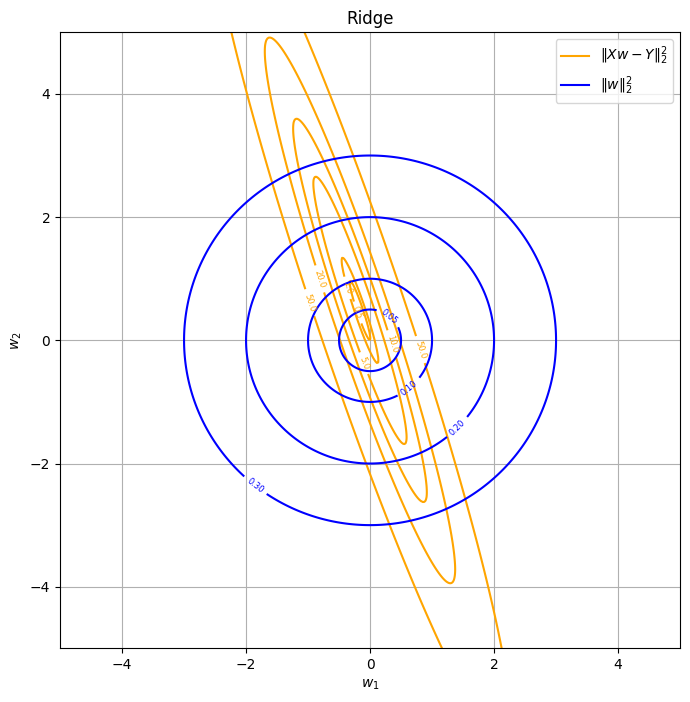

In [5]:
ax, fig = plt.subplots(figsize=(8,8))

def loss(w, X, Y):
    return 0.5/X.shape[0]*np.dot(X@w - Y, X@w - Y)

w1range = [-5, 5]
w2range = [-5, 5]
        
w1 = np.linspace(w1range[0], w1range[1], 500)
w2 = np.linspace(w2range[0], w2range[1], 500)
W1, W2 = np.meshgrid(w1, w2)
Z = np.zeros(W1.shape)
P = np.zeros(W1.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = loss(np.array([W1[i,j],W2[i,j]]), X, Y)
        P[i, j] = 0.1*np.linalg.norm(np.array([W1[i,j],W2[i,j]]))

CS1 = plt.contour(W1, W2, Z, levels=[0.1,0.2,0.5,1.,5,10,20,50], colors='orange')
plt.clabel(CS1, inline=1, fontsize=6) 

CS2 = plt.contour(W1, W2, P, levels=[0.05,0.1,0.2,0.3], colors='blue')
plt.clabel(CS2, inline=1, fontsize=6) 

plt.grid()  

plt.plot([],[], color='orange', label = '$\\|Xw-Y\\|^2_2 $')
plt.plot([],[], color='blue', label = '$\\|w\\|^2_2 $')
plt.xlim(w1range)
plt.ylim(w2range)

plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Ridge')

plt.legend()

## ✂️ Lasso Regression

**Lasso regression** adds a penalty on the **$\ell^1$-norm** of the coefficient vector:

$$
\min_w \; \frac{1}{2N} \|Xw - Y\|_2^2 + \lambda \|w\|_1
$$

Like Ridge regression, Lasso encourages solutions with **smaller coefficients** and can make an **ill-posed problem well-posed**. However, it has the following additional properties:

### 1. ✨ **Sparsity**

The most notable feature of Lasso is that it tends to produce **sparse solutions** — i.e., many coefficients in $w$ are exactly **zero**.

This happens because the level sets of the $\ell^1$-norm are diamond-shaped, and the optimizer often lands on a **corner**, which corresponds to some weights being zero. This makes Lasso especially useful for **feature selection**.


### 2. ⚠️ **Non-Differentiability**

Unlike Ridge, Lasso is **not differentiable** at points where some coefficients are exactly zero. However, in practice, gradient-based optimization methods often approximate the derivative of $|x|$ using:

$$
\frac{d}{dx}|x| \approx \text{sign}(x)
$$

This allows training algorithms like **subgradient descent** to work with Lasso despite the non-differentiability.


### 📊 Visualization

Now we visualize the Lasso **loss landscape**.

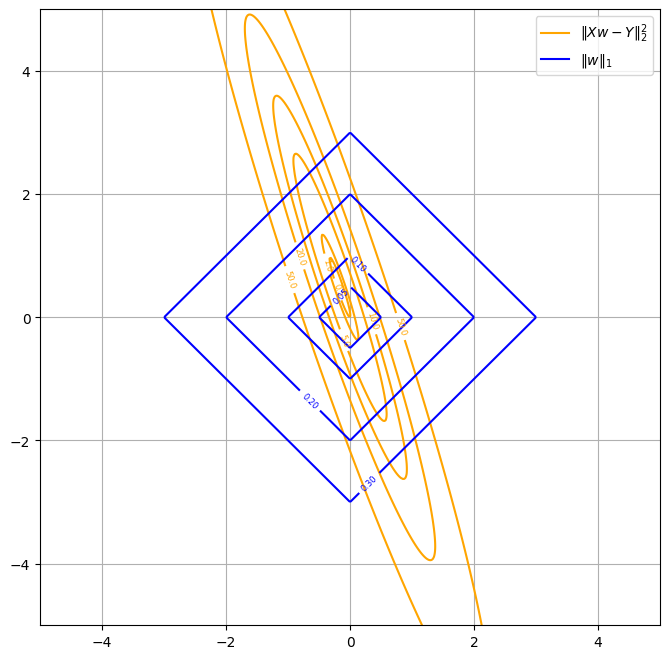

In [6]:
ax, fig = plt.subplots(figsize=(8,8))

def loss(w, X, Y):
    return 0.5/X.shape[0]*np.dot(X@w - Y, X@w - Y)

w1range = [-5, 5]
w2range = [-5, 5]
        
w1 = np.linspace(w1range[0], w1range[1], 500)
w2 = np.linspace(w2range[0], w2range[1], 500)
W1, W2 = np.meshgrid(w1, w2)
Z = np.zeros(W1.shape)
P = np.zeros(W1.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = loss(np.array([W1[i,j],W2[i,j]]), X, Y)
        P[i, j] = 0.1*np.linalg.norm(np.array([W1[i,j],W2[i,j]]),ord=1)

CS1 = plt.contour(W1, W2, Z, levels=[0.1,0.2,0.5,1.,5,10,20,50], colors='orange')
plt.clabel(CS1, inline=1, fontsize=6) 

CS2 = plt.contour(W1, W2, P, levels=[0.05,0.1,0.2,0.3], colors='blue')
plt.clabel(CS2, inline=1, fontsize=6) 

plt.grid()  

plt.plot([],[], color='orange', label = '$\\|Xw-Y\\|^2_2$')
plt.plot([],[], color='blue', label = '$\\|w\\|_1$')
plt.xlim(w1range)
plt.ylim(w2range)

plt.legend()

### 🖼️ Visual Comparison: Ridge vs Lasso Solutions

One more picture to illustrate the difference in the **solutions preferred by Ridge and Lasso**:

![Forms of the constraint regions for Lasso and Ridge regression.](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/L1_and_L2_balls.svg/2880px-L1_and_L2_balls.svg.png)

📌 **Source:** [Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/L1_and_L2_balls.svg/2880px-L1_and_L2_balls.svg.png)


## 📏 Normalization

Another useful technique in machine learning is **feature normalization**, which improves the **numerical behavior** of many learning algorithms, especially those using gradient-based optimization. There are several common normalization strategies:

#### 1. Standardization (Z-score normalization)

Assuming the distribution of a feature is approximately Gaussian, **standardization** transforms it to have **zero mean** and **unit variance**:

$$
\tilde{X}[:,j] = \frac{X[:,j] - \mu_j}{\sigma_j}
$$

Where:
- $\mu_j = \frac{1}{N} \sum_i X[i,j]$ is the empirical mean  
- $\sigma_j^2 = \frac{1}{N-1} \sum_i (X[i,j] - \mu_j)^2$ is the empirical variance

#### 2. Min-Max Normalization

This rescales each feature to a fixed range, typically $[0, 1]$:

$$
\tilde{X}[:,j] = \frac{X[:,j] - \min X[:,j]}{\max X[:,j] - \min X[:,j]}
$$


#### 3. Unit Vector Normalization

This method scales each  **sample** to have unit $\ell^2$-norm:

$$
\tilde{X}[j,:] = \frac{X[j,:]}{\|X[j,:]\|}
$$


In [7]:
df.describe()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,1.546154,12.944077,1.968077,2.340462,18.785385,99.900000,2.522692,2.490000,0.330231,1.752385,4.194769,1.058892,2.954385,790.092308
std,0.499791,0.888769,0.879968,0.297162,3.400459,15.381379,0.545393,0.737765,0.109087,0.539572,1.625782,0.168690,0.475166,352.513026
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,1.100000,0.570000,0.130000,0.410000,1.280000,0.690000,1.590000,278.000000
25%,1.000000,12.227500,1.510000,2.170000,16.525000,88.000000,2.147500,2.002500,0.260000,1.422500,2.862500,0.940000,2.732500,474.000000
50%,2.000000,13.010000,1.730000,2.320000,18.550000,98.000000,2.560000,2.565000,0.300000,1.705000,3.870000,1.050000,2.980000,716.000000
75%,2.000000,13.727500,2.057500,2.527500,20.950000,108.000000,2.937500,2.997500,0.397500,2.005000,5.375000,1.167500,3.300000,1063.750000
max,2.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,8.900000,1.710000,4.000000,1680.000000


### 🧠 Why Normalize?

Looking at our dataset, we see that **different features (columns) have very different ranges**.  
This means that coefficients of similar scale, when applied to different features, can cause very different effects on the model’s output.

In other words, the spectrum of $X^T X$ may contain **very large and very small eigenvalues**.

> The **maximum feasible learning rate** for gradient descent is proportional to:
>
> $$
> \eta_{\text{max}} = \frac{1}{\lambda_{\text{max}}(X^T X)}
> $$

This means that:
- Columns with large values **limit how large the learning rate can be**.
- That same small learning rate may be **too slow** to learn weights for smaller-scale features.

We define a function for **standardizing** our data:

In [8]:
def normalize(x):
    return (x - np.mean(x, axis=0))/np.std(x,axis=0)

# Ridge implementation

We implement **Ridge classification** as a **child class** of our `LinearBinaryClassification` class from the previous session.
Many methods, including the gradient descent training routine (`LinearBinaryClassification.fit()`), are **inherited without modification**.

> ### 💡 Gradients Calculation
>We consider the Ridge regression objective with an intercept term:
>
>$$
>\mathcal{L}(w, b) = \frac{1}{2N} \|Xw + b\mathbf{1}_N - Y\|_2^2 + \lambda \|w\|_2^2
>$$
>
>**Gradient with respect to** $w$:
>
>$$
>\nabla_w \mathcal{L}(w, b) = \frac{1}{N} X^T (Xw + b\mathbf{1}_N - Y) + 2\lambda w
>$$
>
>**Gradient with respect to** $b$:
>
>$$
>\nabla_b \mathcal{L}(w, b) = \frac{1}{N} \mathbf{1}_N^T (Xw + b\mathbf{1}_N - Y)
>$$

📌 Note: Only $w$ is regularized — the intercept $b$ is **not** penalized.

In [9]:
class LinearBinaryClassification:
    """
    Linear binary classification class.

    Stores a linear classification model with parameters (w,b)
    and decision function h(x) = sign(w @ x + b)

    Parameters:
    ----------
    w: array
    b: array

    """
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def decision_function(self, x):
        return x @ self.w + self.b
    
    def __call__(self, x):
        # Numpy's `where` function provides a fast substitution
        return np.where(self.decision_function(x) >= 0.0, 1, -1)
    

class RidgeClassifier(LinearBinaryClassification):
    """
    Ridge binary classifier
    """
    def __init__(self, w, b, lam=0.1):
        super().__init__(w, b)
        self.lam = lam


    def loss_grad(self, X,Y):
        """Loss gradient"""
        residual = self.decision_function(X) - Y
        w_grad = X.T@residual/X.shape[0] + 2*self.lam*self.w
        b_grad = np.mean(residual, axis=0)
        return w_grad, b_grad
    
    def update(self, X, Y, lr = 1e-3):
        """Single step of GD"""
        grad_w, grad_b = self.loss_grad(X,Y)
        self.w -= lr*grad_w
        self.b -= lr*grad_b
               
    def fit(self, X, Y, lr = 1e-3, num_iter = 100):
        """GD training loop with num_iter epochs"""
        for _ in range(num_iter):
            self.update(X, Y, lr)
            
        return self.w, self.b

#### Evaluation functions

As in the last homework, we define functions we are going to evaluate outside of the model class.

In [10]:
def accuracy(y_pred,y_true):
    pred_labels = np.where(y_pred >= 0.0, 1, -1)
    return np.mean(pred_labels == y_true)*100

def MSE(y_pred,y_true):
    """Loss function"""
    return 0.5*np.mean((y_pred - y_true)**2, axis=0)

## 📉 Effects of $ \lambda $

Let us run the model and observe how the **regularization parameter** $ \lambda $ affects the learned solution.

In [11]:
X = df.iloc[:,df.columns != 'Class'].to_numpy()
Y = df['Class'].replace([1,2],[1,-1]).to_numpy()

X = normalize(X)

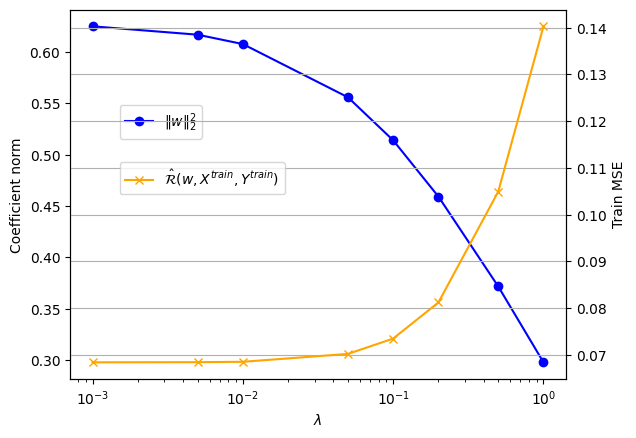

In [12]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

w = np.array([0.]*X.shape[-1])
b = 0.

ls = [0.001,0.005,0.01,0.05,0.1,0.2,0.5,1.]
w_norms = []
accuracies = []
losses = []
coefs = []

for l in ls:

    model = RidgeClassifier(w, b, lam=l)
    model.fit(X,Y, lr = 1e-1, num_iter = 1000)
    
    accuracies.append(accuracy(model.decision_function(X),Y))
    w_norms.append(np.linalg.norm(model.w))
    losses.append(MSE(model.decision_function(X),Y))
    coefs.append(model.w.copy())
    

ax.plot(ls, w_norms, color = 'blue', marker='o', label = '$\\|w\\|^2_2$')   
ax2.plot(ls, losses, color = 'orange', marker='x', label = '$\\hat{\\mathcal{R}}(w,X^{train},Y^{train})$')   
ax.set_xscale('log')
    
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('Coefficient norm')
ax2.set_ylabel('Train MSE')
plt.grid()
ax.legend(loc=(0.1,0.65))
ax2.legend(loc=(0.1,0.5))

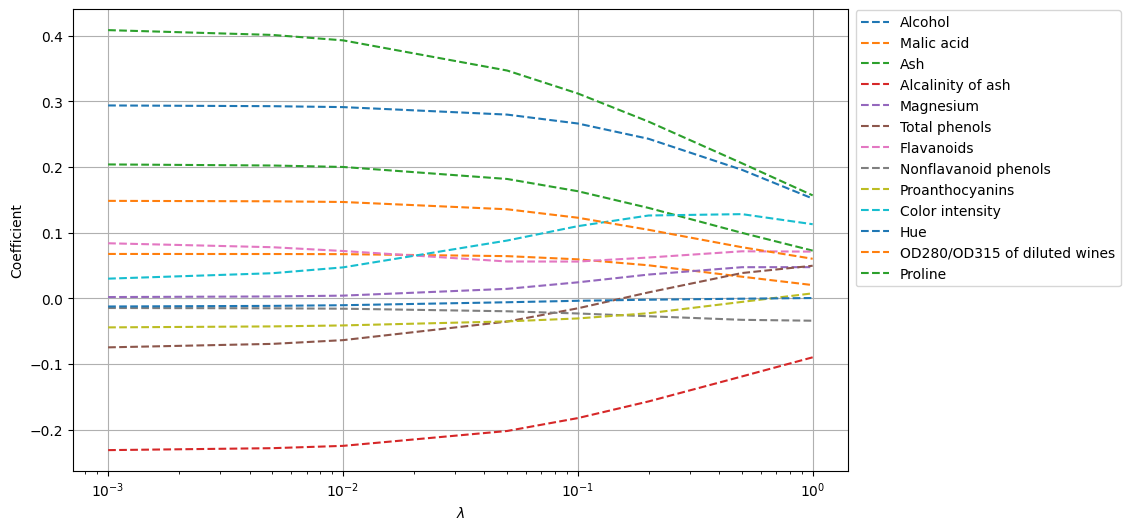

In [13]:
coefs = np.array(coefs)

fig, ax = plt.subplots(figsize=(10,6))

for i in range(coefs.shape[1]):
    plt.plot(ls, coefs[:,i], ls='--', label=df.columns[i+1])

plt.legend(loc=(1.01,0.4))
plt.grid()
plt.xlabel('$\\lambda$')
plt.ylabel('Coefficient')
plt.xscale('log')

# 🔁 Cross-Validation

### How to choose the value of the regularization hyperparameter $ \lambda $?

In practice, it's usually impossible to guess the best value of $ \lambda $ ahead of time.  
Instead, we train **multiple models** with different hyperparameter values and **compare their performance** to select the one that works best.


### ✅ Model Validation

To compare models fairly, we need a model **validation strategy**.

Earlier, we used a simple split:  
- Train the model on the **training set**
- Evaluate it on the **test set**  
This gives a **single estimate** of the model's generalization performance.


### 📦 Cross-Validation (CV)

A more general and robust approach is **Cross-Validation (CV)**.

In **K-fold cross-validation**:
- The dataset is split into $ k $ equally-sized parts:  
  $$ X = \bigsqcup_{i=1}^k X_i $$
- For each fold $ i $, we:
  - Train the model on $ X \setminus X_i $
  - Evaluate it on $ X_i $

This way, each data point gets to be in the test set exactly once.  
The **average validation performance** across folds gives a more reliable estimate of model performance.


### 📊 Illustration

<div align="left">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/2880px-K-fold_cross_validation_EN.svg.png" width="600">
</div>

📌 **Source:** [Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/2880px-K-fold_cross_validation_EN.svg.png)


Cross-validation is widely used for:
- Hyperparameter tuning (like $ \lambda $ in Ridge/Lasso)
- Model comparison
- Performance estimation when data is limited


Here we will use CV to compare models with different choices of $\lambda$.

In [14]:
def k_fold_split(X,Y,k):
    perm_ind = np.random.permutation(np.arange(X.shape[0]))
    return np.array_split(X[perm_ind],k), np.array_split(Y[perm_ind],k)

In [15]:
X_cv, Y_cv = k_fold_split(X,Y,k=5)

In [16]:
ls = [0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1.]

mse_by_fold = []
for i in range(len(X_cv)):
    x_train = np.concatenate(X_cv[:i] + X_cv[i+1:])
    y_train = np.concatenate(Y_cv[:i] + Y_cv[i+1:])
    x_test = X_cv[i]
    y_test = Y_cv[i]
    
    mse_by_fold.append([]) 
    for l in ls:
        model = RidgeClassifier(w, b, lam=l)
        model.fit(x_train, y_train, lr = 1e-1, num_iter = 500)

        mse_by_fold[-1].append(MSE(model.decision_function(x_test),y_test))

Best lambda value (CV estimate): 0.1


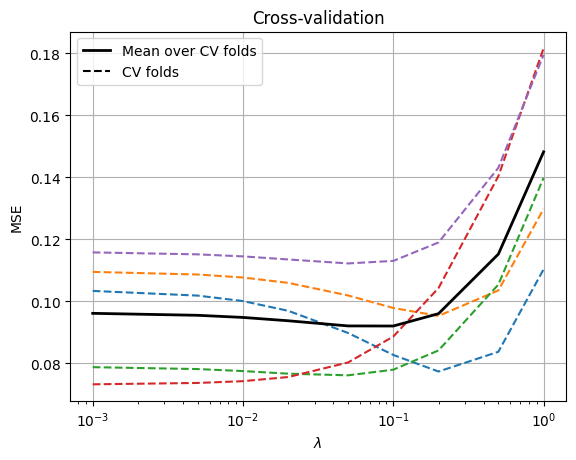

In [17]:
for i in range(len(X_cv)):
    plt.plot(ls,mse_by_fold[i],ls='--')

mean_cv_mse = np.mean(np.array(mse_by_fold),axis=0)
plt.plot(ls,mean_cv_mse, color='k', linewidth=2, label='Mean over CV folds')
plt.plot([],[],ls='--',color='k', label='CV folds')
plt.xscale('log')

plt.xlabel('$\\lambda$')
plt.ylabel('MSE')
plt.title('Cross-validation')
plt.grid()
plt.legend()

best_l = ls[np.argmin(mean_cv_mse)]
print(f"Best lambda value (CV estimate): {best_l}")

# Exercise: Lasso Classifier

Implement a **Lasso classifier** as a new **child class** of `LinearBinaryClassification`. The objective function is:

$$
\mathcal{L}(w, b) = \frac{1}{2N} \|Xw + b\mathbf{1}_N - Y\|_2^2 + \lambda \|w\|_1
$$

📌 **Note:** The $ \ell^1 $ norm is **not differentiable** at 0. However, for gradient-based optimization, we assume:

$$
\frac{\partial}{\partial w_i} |w_i| = \text{sign}(w_i)
$$

You can use `np.sign(w)` in your implementation.